In [1]:
# To be able to make edits to repo without having to restart notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy import signal
from scipy import ndimage
from math import ceil
import cv2
import itertools

PROJECT_PATH = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
# PROJECT_PATH = os.getcwd()
sys.path.append(os.path.dirname(PROJECT_PATH))

from _prototypes.cell_remapping.src.remapping import pot_sliced_wasserstein
from _prototypes.cell_remapping.src.wasserstein_distance import _get_ratemap_bucket_midpoints

unit_matcher_path = os.getcwd()
prototype_path = os.path.abspath(os.path.join(unit_matcher_path, os.pardir))
project_path = os.path.abspath(os.path.join(prototype_path, os.pardir))
lab_path = os.path.abspath(os.path.join(project_path, os.pardir))
sys.path.append(project_path)
os.chdir(project_path)
print(project_path)

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\_prototypes


In [3]:
def make_single_grid(N=3, sliceN=16, gapN=ceil(3/2), full_map_dims=8, stdev=3, shift_row=0, shift_col=0, custom_gauss=None, smooth=True, getFullGrid=False, smoothStd=None):
    
    shift_row = shift_row - int(shift_row/gapN) * ceil(gapN)

    # print(shift_col)
    shift_col = shift_col - int(shift_col/gapN) * ceil(gapN)
    # print(shift_col)

    # print(shift_row, shift_col)
    k1d = signal.gaussian(N, std=stdev).reshape(N, 1)
    kernel = np.outer(k1d, k1d)
    blank_map = np.zeros((full_map_dims, full_map_dims))
    single_field = np.copy(blank_map)
    for i in range(int(full_map_dims/gapN)+1):
        for j in range(int(full_map_dims/gapN)+1):
            if i % 2 == 0:
                rowid = N+i*gapN + shift_row
                colid = N+j*gapN + shift_col
                if rowid < len(single_field) and colid < len(single_field):
                    single_field[rowid, colid] = 1 
            else:
                # if gapN/2 % 2 != 0:
                #     inc = ceil(gapN/2)+1
                # else:
                #     inc = ceil(gapN/2)
                rowid = N+i*gapN + shift_row
                colid = N+j*gapN + shift_col + int(gapN/2)
                if rowid < len(single_field) and colid < len(single_field):
                    single_field[rowid, colid] = 1 
    row, col = np.where(single_field == 1)
    assert len(row) == len(col)
    for i in range(len(row)):
        # print(i, row[i], col[i])
        rowend = row[i]+ceil(N/2)
        colend = col[i]+ceil(N/2)
        if colend >= len(single_field):
            colend -= len(single_field)
            colinter = N - colend
        else:
            colinter = N
        if rowend >= len(single_field):
            rowend -= len(single_field)
            rowinter = N - rowend
        else:
            rowinter = N

        if N % 2 == 0:
            single_field[row[i]-ceil(N/2):row[i]+ceil(N/2), col[i]-ceil(N/2):col[i]+ceil(N/2)] = kernel[:rowinter, :colinter]
        else:
            single_field[row[i]-N//2:row[i]+ceil(N/2), col[i]-N//2:col[i]+ceil(N/2)] = kernel[:rowinter, :colinter]

    if smooth:
        if smoothStd is not None:
            single_field = ndimage.gaussian_filter(single_field, smoothStd)
        else:
            single_field = ndimage.gaussian_filter(single_field, int(stdev/2))
    # single_field = single_field[64:64+64, 64:64+64]
    # plt.imshow(single_field, cmap='jet')
    # plt.show()
    if getFullGrid:
        return single_field
    else:
        single_field = single_field[N+sliceN:sliceN+N+sliceN, N+sliceN:sliceN+N+sliceN]
        return single_field


In [4]:
N = 3 # kernel size
gapN = N*N 
if gapN % 2 != 0:
    gapN += 1
sliceN = 17
stdev = 2
px = np.arange(0,sliceN,1)
py = np.arange(0,sliceN,1)
mesh = np.meshgrid(px, py)
k1d = signal.gaussian(N, std=stdev).reshape(N, 1)
kernel = np.outer(k1d, k1d)
# full_map_dims = sliceN*3 + int(sliceN/2)
full_map_dims = sliceN * 8 + N * 2
blank_map = np.zeros((full_map_dims, full_map_dims))

# circle_left_ex1 = single_field

aggregate_circle_right_ex2 = []
sxs = [0,1,2,3,4,5,6,7,8,9,10,11]
full_grid = make_single_grid(N, sliceN, gapN, full_map_dims, stdev, shift_row=0, shift_col=0, smooth=True, getFullGrid=True)

# sxs = [64]
for i in range(len(sxs)):
    # single_field = np.copy(blank_map)
    # # single_field[64+32, 64+sxs[i]] = 1 
    # for i2 in range(25):
    #     for j in range(25):
    #         if i2 % 2 == 0:
    #             single_field[N+i2*ceil(fullN/4), N+j*ceil(fullN/4) + sxs[i]] = 1 
    #         else:
    #             single_field[N+i2*ceil(fullN/4), N+j*ceil(fullN/4)+ceil(fullN/8) + sxs[i]] = 1  
    # row, col = np.where(single_field == 1)
    # # print(row, col)
    # for k in range(len(row)):
    #     # print(row[k], k, len(row),col[k])
    #     # print(row[k]-(N//2),row[k]+(N//2)+1, col[k]-(N//2),col[k]+(N//2)+1)
    #     single_field[row[k]-(N//2):row[k]+(N//2)+1, col[k]-(N//2):col[k]+(N//2)+1] = kernel
    # single_field = ndimage.gaussian_filter(single_field, 2)
    # single_field = single_field[N+fullN:fullN+N+fullN, N+fullN:fullN+N+fullN]
    # # single_field = single_field[63:63+63, 63:63+63]

    # single_field = make_single_grid(N, fullN, stdev, shift_row=0, shift_col=sxs[i], smooth=True)
    single_field = full_grid[N+sliceN:N+sliceN+sliceN, N+sliceN - sxs[i]:N+sliceN+sliceN - sxs[i]]
    if i == 0:
        circle_left_ex2 = single_field

        
    aggregate_circle_right_ex2.append(single_field)


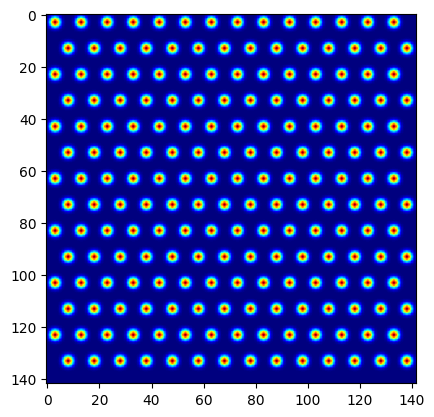

In [5]:
plt.imshow(full_grid, cmap='jet')

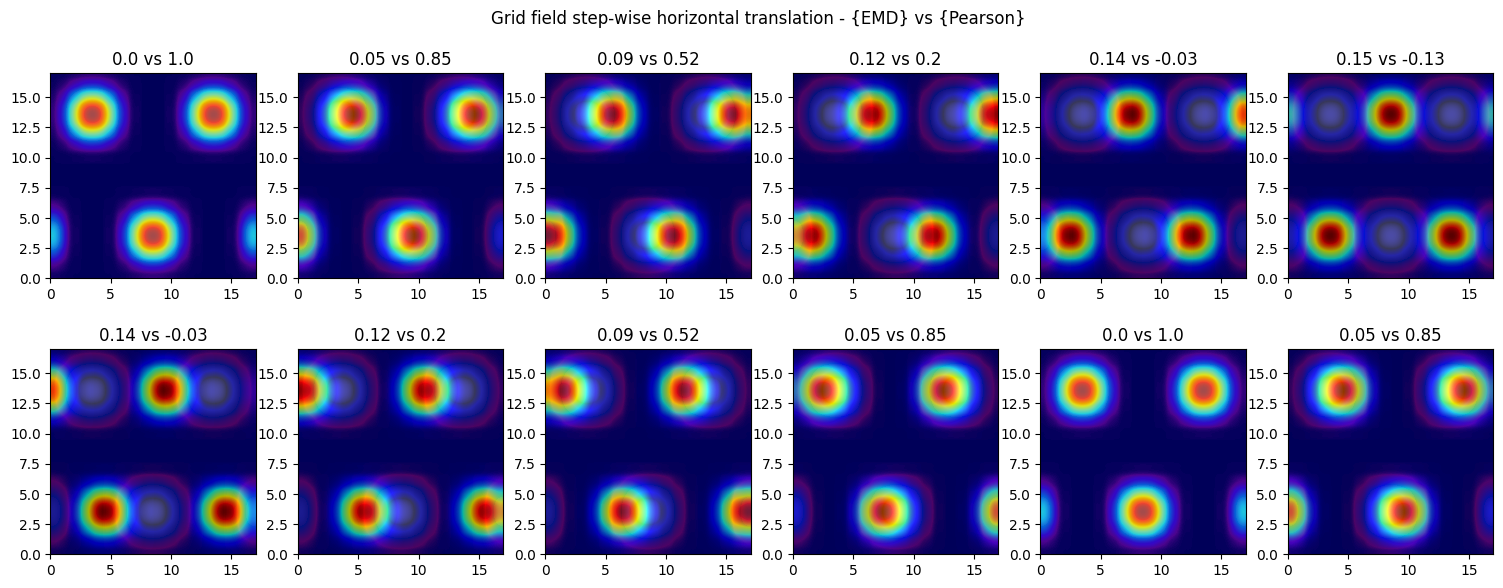

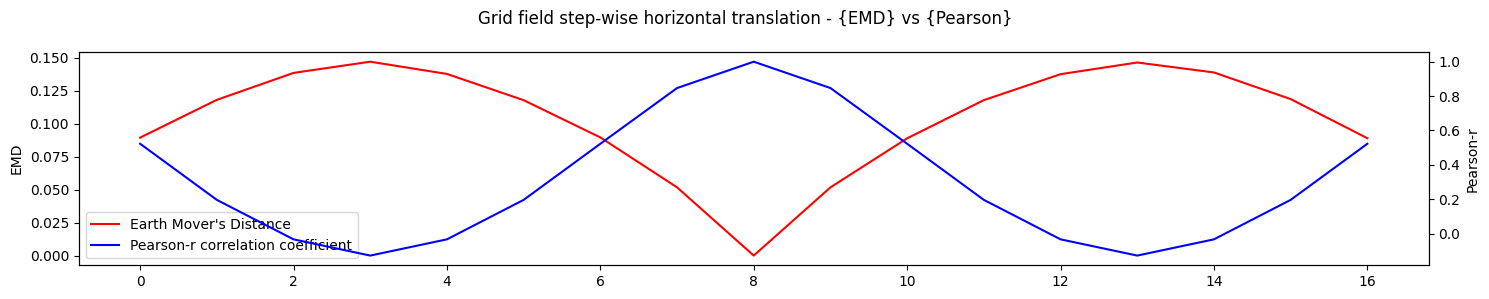

In [6]:
def _interpolate_matrix(matrix, new_size=(257,257), cv2_interpolation_method=cv2.INTER_CUBIC):
    '''
        Interpolate a matrix using cv2.INTER_LANCZOS4.
    '''
    return cv2.resize(matrix, dsize=new_size,
                      interpolation=cv2_interpolation_method)

"""""""""""""""""""""" EXAMPLE 1 """""""""""""""""""""
""" No overlap same shape = elliptic_left_ex1 and elliptic_right_ex1 """

fig = plt.figure(figsize=(15,6))

c = 0
for circle_right_ex2 in aggregate_circle_right_ex2:

    ax = plt.subplot(2,6,c+1)
    ax.imshow(_interpolate_matrix(circle_right_ex2), cmap='jet', extent=[0,sliceN,0,sliceN])
    ax.imshow(_interpolate_matrix(circle_left_ex2), cmap='gist_stern', alpha=0.3, extent=[0,sliceN,0,sliceN])

    y, x = circle_left_ex2.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: circle_left_ex2[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: circle_right_ex2[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    # emd = pot.wass
    r, p = spearmanr(source_weights.flatten(), target_weights.flatten())

    ax.set_title(str(round(emd, 2)) + ' vs ' + str(round(r, 2)))

    c += 1

fig.suptitle('Grid field step-wise horizontal translation - {EMD} vs {Pearson}')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(15,3))
emds = []
pearsons = []
rx, ry = 1, 1
rot = 45
circle_right_ex2_full_grid = make_single_grid(N, sliceN, gapN, full_map_dims, stdev, shift_row=0, shift_col=0, smooth=True, getFullGrid=True)

for i in np.arange(-int(sliceN/2),ceil(sliceN/2),1):
    # fld = make_single_field(N, stdev, shift_row=-ceil(N/2)+i, shift_col=0 ,custom_gauss=aggregate_elliptic_right_ex1[0])
    # fld = fld[N:N+N,N:N+N]

    # sx, sy = N/2, N/2 + i
    # circle_right_ex2 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 
    # circle_right_ex2 = make_single_grid(N, fullN, stdev, shift_row=0, shift_col=i, smooth=True)
    circle_right_ex2 = circle_right_ex2_full_grid[N+sliceN:sliceN+N+sliceN, N+sliceN + int(i) :sliceN+N+sliceN + int(i)]

    # print(circle_right_ex2.shape, circle_left_ex1.shape)
    y, x = circle_left_ex2.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: circle_left_ex2[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: circle_right_ex2[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    r, p = spearmanr(source_weights.flatten(), target_weights.flatten())

    emds.append(emd)
    pearsons.append(r)

ax  = plt.subplot(1,1,1)
ln1 = ax.plot(emds,label="Earth Mover's Distance",color='r')
axt = ax.twinx()
ln2 = axt.plot(pearsons, label='Pearson-r correlation coefficient',color='b')
ax.set_ylabel('EMD')
axt.set_ylabel('Pearson-r')
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
fig.suptitle('Grid field step-wise horizontal translation - {EMD} vs {Pearson}')
fig.tight_layout()
plt.show()


In [7]:

"""""""""""""""""""""" EXAMPLE 3 - POPULATION FIGURES """""""""""""""""""""
""" Overlap same shape = circle_left_ex1 and circle_right_ex1 """

y, x = circle_left_ex2.shape
height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
source_weights = np.array(list(map(lambda x: circle_left_ex2[x[0],x[1]], buckets)))
source_weights = source_weights / np.sum(source_weights)
coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))
pop_shifted_emd = np.zeros(circle_left_ex2.shape)
pop_shifted_pearson = np.zeros(circle_left_ex2.shape)

circle_right_ex2_full_grid = make_single_grid(N, sliceN, gapN, full_map_dims, stdev, shift_row=0, shift_col=0, smooth=True, getFullGrid=True)

rx, ry = 1, 1

def _sub1(i, j):
    sx, sy = i, j
    rot = 45
    # circle_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 
    circle_right_ex2 = circle_right_ex2_full_grid[N+sliceN:sliceN+N+sliceN, N+sliceN + int(i) :sliceN+N+sliceN + int(i)]

    target_weights = np.array(list(map(lambda y: circle_right_ex2[y[0],y[1]], buckets)))
    target_weights = target_weights / np.sum(target_weights)
    
    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    # emd = 0
    r, p = spearmanr(source_weights.flatten(), target_weights.flatten())

    return emd, r

def _sub2(i):
    print(i)
    emd_and_r = np.array(list(map(lambda x: _sub1(i, x), np.arange(0,len(pop_shifted_emd)))))
    return emd_and_r[:,0], emd_and_r[:,1]

combined = np.array(list(map(lambda x: _sub2(x), np.arange(0,len(pop_shifted_emd)))))
pop_shifted_emd, pop_shifted_pearson = combined[:,0,:].T, combined[:,1,:].T


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


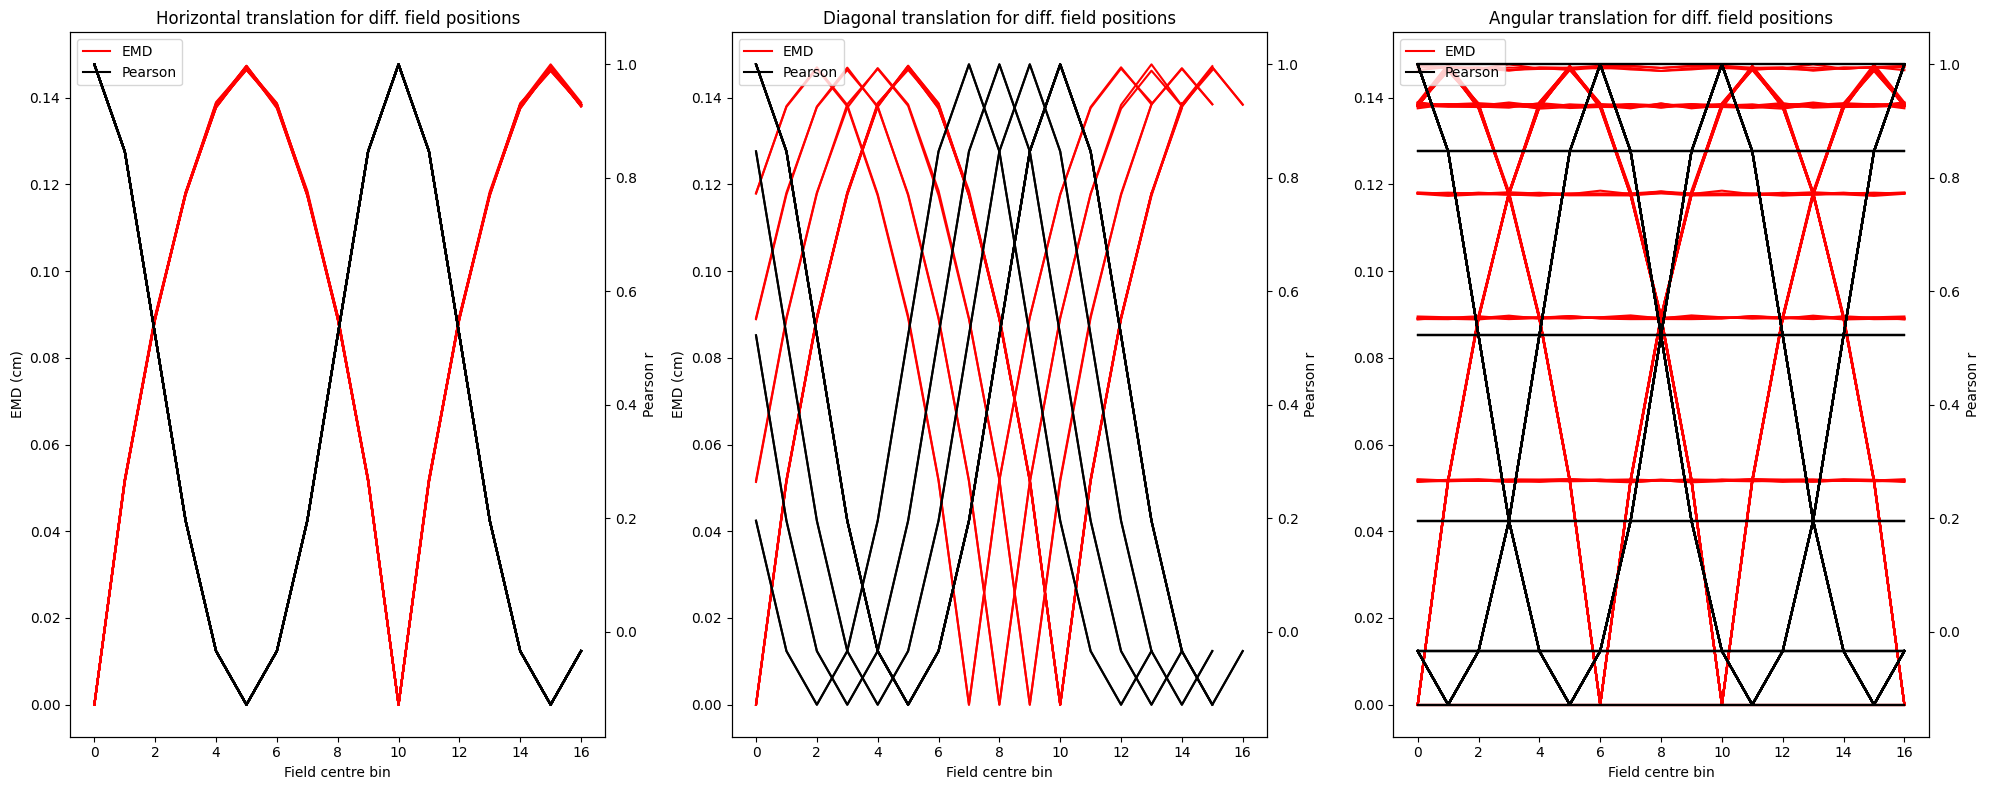

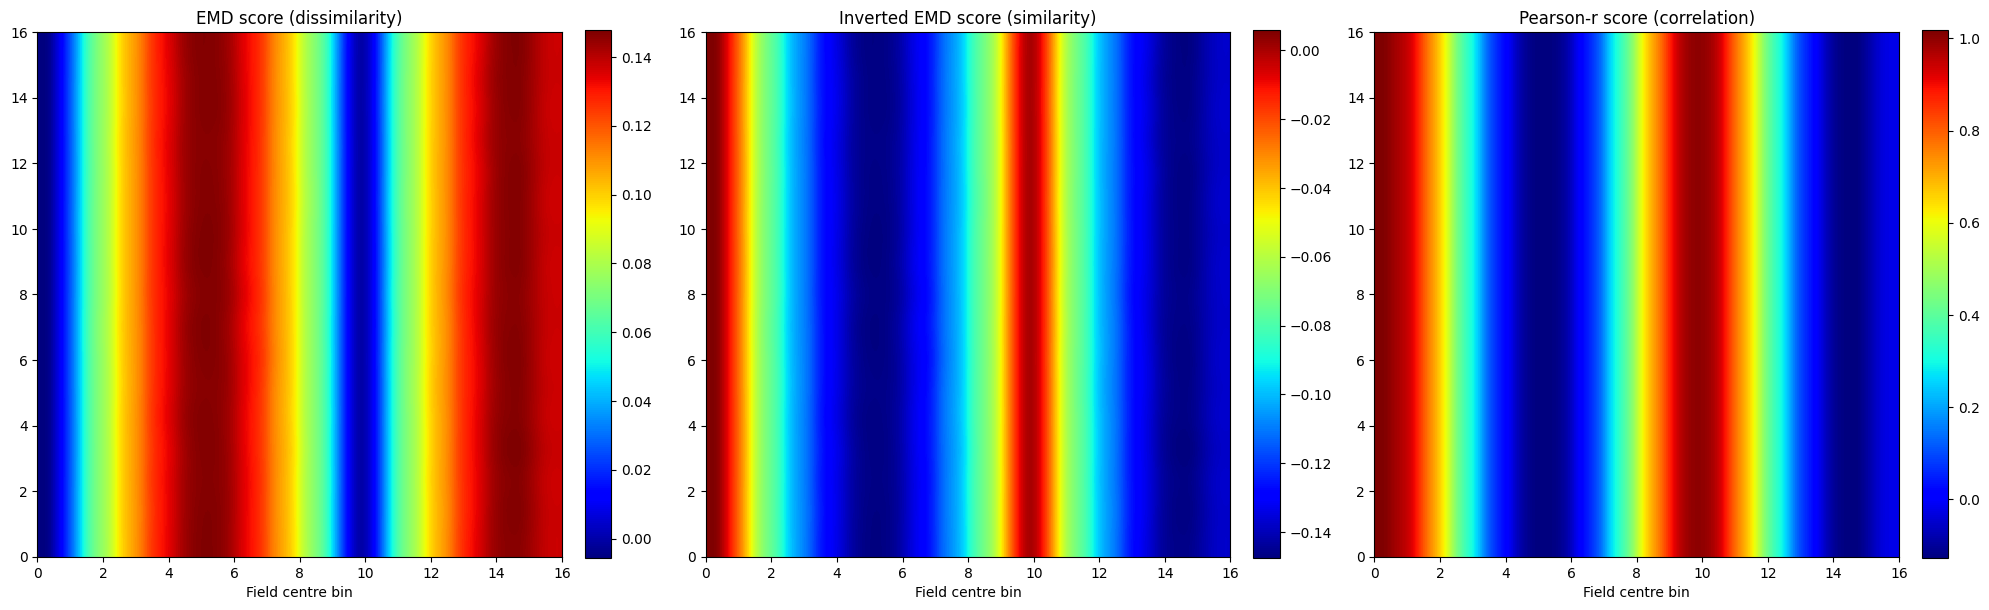

In [8]:
fig, _ = plt.subplots(1, 3, figsize=(20, 8))
ax1 = plt.subplot(1,3,1)
for i in range(len(pop_shifted_emd)):
    p1 = ax1.plot(pop_shifted_emd[i],color='r',label='EMD')
ax1.set_xlabel('Field centre bin')
ax1.set_ylabel('EMD (cm)')
axtwin = ax1.twinx()
axtwin.set_ylabel('Pearson r')
for i in range(len(pop_shifted_pearson)):
    ptwin = axtwin.plot(pop_shifted_pearson[i],color='k',label='Pearson')
lns = p1+ptwin
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')
# ax1.set_aspect('equal')
ax1.set_title('Horizontal translation for diff. field positions')

def diag_matrix(matrix):
    diags = [matrix[::-1,:].diagonal(i) for i in range(-3,4)]
    diags.extend(matrix.diagonal(i) for i in range(3,-4,-1))
    return [n.tolist() for n in diags]

ax2 = plt.subplot(1,3,2)

diag_emd = diag_matrix(pop_shifted_emd)
for i in range(len(diag_emd)):
    p2 = ax2.plot(diag_emd[i],color='r',label='EMD')
ax2.set_xlabel('Field centre bin')
ax2.set_ylabel('EMD (cm)')
axtwin2 = ax2.twinx()
axtwin2.set_ylabel('Pearson r')
diag_pearson = diag_matrix(pop_shifted_pearson)
for i in range(len(diag_pearson)):
    ptwin2 = axtwin2.plot(diag_pearson[i],color='k',label='Pearson')
lns = p2+ptwin2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='upper left')
ax2.set_title('Diagonal translation for diff. field positions')

ax3 = plt.subplot(1,3,3)
rotated_emd = np.array(list(map(lambda x: ndimage.rotate(pop_shifted_emd, x, reshape=False, mode='constant', cval=np.nan), np.arange(0,360,90))))
pdct_emd = list(itertools.product(np.arange(len(rotated_emd)), np.arange(len(rotated_emd[0]))))
list(map(lambda x: ax3.plot(rotated_emd[x[0],x[1]],color='r',label='EMD'), pdct_emd))
p3 = ax3.plot(rotated_emd[0,0],color='r',label='EMD')
# for i in range(len(rotated_emd)):
#     for j in range(len(rotated_emd[i])):
axtwin3 = ax3.twinx()
axtwin3.set_ylabel('Pearson r')
rotated_pearson = np.array(list(map(lambda x: ndimage.rotate(pop_shifted_pearson, x, reshape=False, mode='constant', cval=np.nan), np.arange(0,360,90))))
# for i in range(len(rotated_pearson)):
#     for j in range(len(rotated_pearson[i])):
pdct_pearson = list(itertools.product(np.arange(len(rotated_pearson)), np.arange(len(rotated_pearson[0]))))
list(map(lambda x: axtwin3.plot(rotated_pearson[x[0],x[1]],color='k',label='EMD'), pdct_pearson))
ptwin3 = axtwin3.plot(rotated_pearson[0,0],color='k',label='Pearson')
lns = p3+ptwin3
labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, loc='upper left')
ax3.set_title('Angular translation for diff. field positions')
ax3.set_xlabel('Field centre bin')

fig.tight_layout()
plt.show()

fig, _ = plt.subplots(1, 2, figsize=(20, 8))

ax4 = plt.subplot(1,3,1)
im = ax4.imshow(_interpolate_matrix(pop_shifted_emd), cmap='jet', aspect='equal', extent=[0,sliceN-1,0,sliceN-1])
ax4.set_title('EMD score (dissimilarity)')
ax4.set_xlabel('Field centre bin')
fig.colorbar(im, ax=ax4,fraction=0.046, pad=0.04)

ax5 = plt.subplot(1,3,2)
im = ax5.imshow(_interpolate_matrix(-pop_shifted_emd), cmap='jet', aspect='equal', extent=[0,sliceN-1,0,sliceN-1])
ax5.set_title('Inverted EMD score (similarity)')
ax5.set_xlabel('Field centre bin')
fig.colorbar(im, ax=ax5,fraction=0.046, pad=0.04)

ax6 = plt.subplot(1,3,3)
ax6.set_xlabel('Field centre bin')
im = ax6.imshow(_interpolate_matrix(pop_shifted_pearson), cmap='jet', aspect='equal', extent=[0,sliceN-1,0,sliceN-1])
ax6.set_title('Pearson-r score (correlation)')
fig.colorbar(im, ax=ax6,fraction=0.046, pad=0.04)

fig.tight_layout()
plt.show()

In [9]:
agg_pop_shifted_emd = []
# projection_count = [0,1,2,3,4]
# proj_counts = [1,2,5,7,10,25,50,75,100,250,500,750,1000,2500,5000,7500,10000]
proj_counts = np.arange(0,51,1)
proj_counts = np.hstack((proj_counts, [75,100,250,500,750,1000,2500,5000,7500,10000]))

for n_proj in proj_counts:
    print(n_proj)
    y, x = circle_left_ex2.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: circle_left_ex2[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))
    pop_shifted_emd = np.zeros(circle_left_ex2.shape)
    pop_shifted_pearson = np.zeros(circle_left_ex2.shape)

    circle_right_ex2_full_grid = make_single_grid(N, sliceN, gapN, full_map_dims, stdev, shift_row=0, shift_col=0, smooth=True, getFullGrid=True)

    rx, ry = 1, 1

    def _sub1(i, j):
        sx, sy = i, j
        rot = 45
        # circle_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 
        circle_right_ex2 = circle_right_ex2_full_grid[N+sliceN:sliceN+N+sliceN, N+sliceN + int(i) :sliceN+N+sliceN + int(i)]

        target_weights = np.array(list(map(lambda y: circle_right_ex2[y[0],y[1]], buckets)))
        target_weights = target_weights / np.sum(target_weights)
        
        # emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**n_proj)

        emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=n_proj)

        # emd = 
        r, p = spearmanr(source_weights.flatten(), target_weights.flatten())

        return emd, r

    def _sub2(i):
        emd_and_r = np.array(list(map(lambda x: _sub1(i, x), np.arange(0,len(pop_shifted_emd)))))
        return emd_and_r[:,0], emd_and_r[:,1]

    combined = np.array(list(map(lambda x: _sub2(x), np.arange(0,len(pop_shifted_emd)))))
    pop_shifted_emd, pop_shifted_pearson = combined[:,0,:].T, combined[:,1,:].T

    agg_pop_shifted_emd.append(pop_shifted_emd)


0
1


c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\_prototypes\cell_remapping\src\wasserstein_distance.py:451: RuntimeWarning: invalid value encountered in double_scalars
  res = (nx.sum(projected_emd) / n_projections) ** (1.0 / p)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
75
100
250
500
750
1000
2500
5000
7500
10000


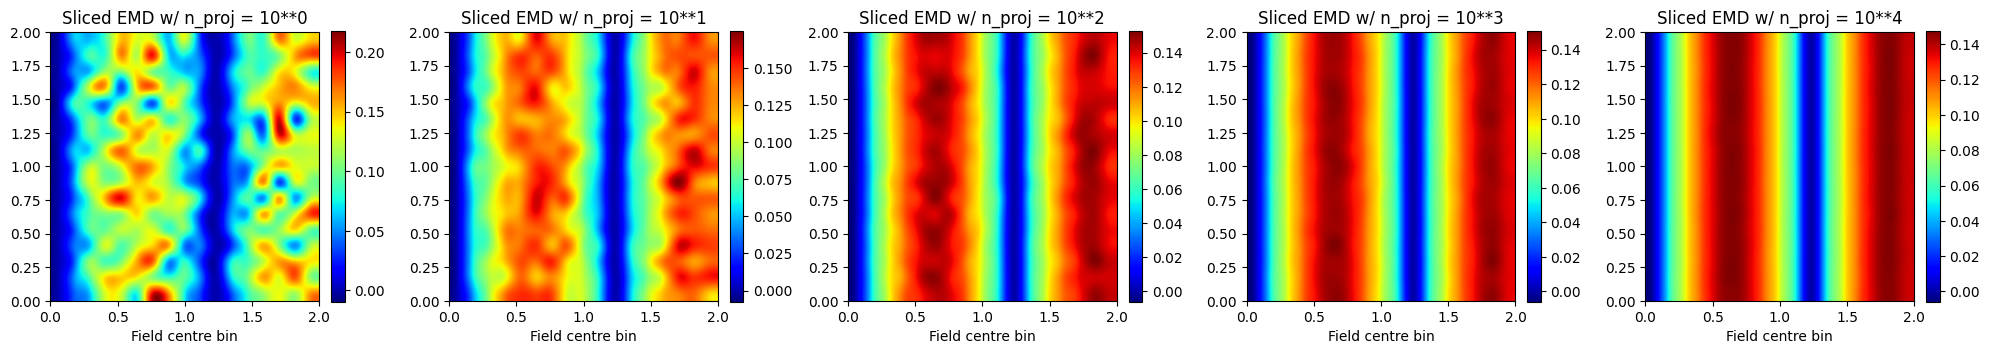

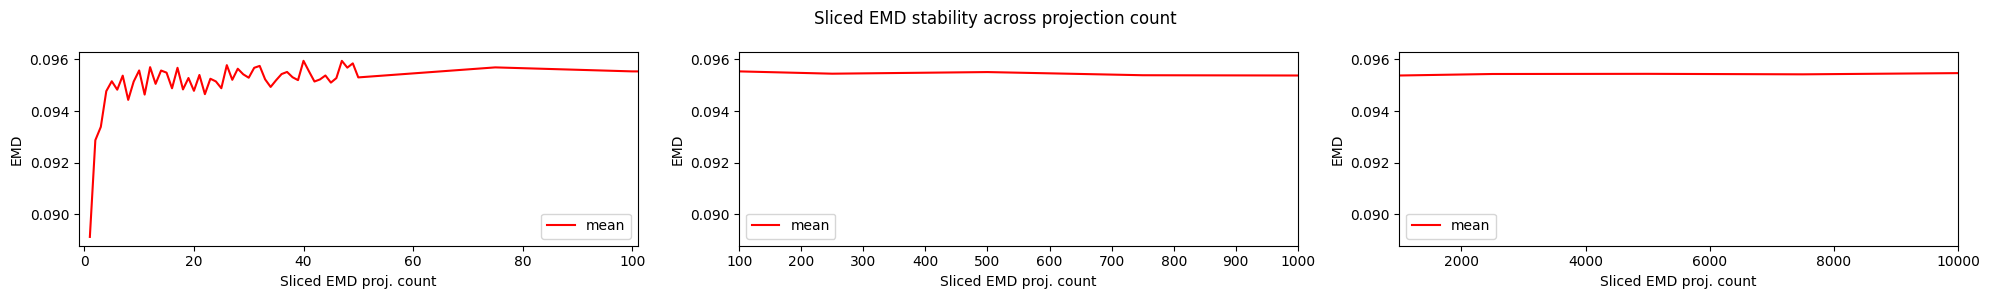

In [10]:
fig, _ = plt.subplots(1, 2, figsize=(20, 8))

# proj_counts = np.array([1,2,5,7,10,25,50,75,100,250,500,750,1000,2500,5000,7500,10000])
proj_counts = np.arange(0,51,1)
proj_counts = np.hstack((proj_counts, [75,100,250,500,750,1000,2500,5000,7500,10000]))
first_plot = np.array([1,10,100,1000,10000])
projection_count = [0,1,2,3,4]

for i in range(len(first_plot)):

    idx = np.where(proj_counts == first_plot[i])[0][0]

    ax4 = plt.subplot(1,len(first_plot),i+1)
    im = ax4.imshow(_interpolate_matrix(agg_pop_shifted_emd[idx]), cmap='jet', aspect='equal', extent=[0,N-1,0,N-1])
    ax4.set_title('Sliced EMD w/ n_proj = 10**' + str(projection_count[i]))
    ax4.set_xlabel('Field centre bin')
    fig.colorbar(im, ax=ax4,fraction=0.046, pad=0.04)


fig.tight_layout()
plt.show()

avgs = list(map(lambda x: np.mean(agg_pop_shifted_emd[x]), np.arange(len(agg_pop_shifted_emd))))
# upper = list(map(lambda x: np.mean(agg_pop_shifted_emd[x]) + 2 * np.std(agg_pop_shifted_emd[x]), np.arange(len(agg_pop_shifted_emd))))
# lower = list(map(lambda x: np.mean(agg_pop_shifted_emd[x]) - 2 * np.std(agg_pop_shifted_emd[x]), np.arange(len(agg_pop_shifted_emd))))


fig = plt.figure(figsize=(20,3))

ax = plt.subplot(1,3,1)
ax.plot(proj_counts, avgs, color='r', label='mean')
ax.set_xlabel('Sliced EMD proj. count')
ax.set_ylabel('EMD')
ax.set_xlim(-1,101)
ax.legend()

ax = plt.subplot(1,3,2)
ax.plot(proj_counts, avgs, color='r', label='mean')
ax.set_xlabel('Sliced EMD proj. count')
ax.set_ylabel('EMD')
ax.set_xlim(100,1000)
ax.legend()

ax = plt.subplot(1,3,3)
ax.plot(proj_counts, avgs, color='r', label='mean')
ax.set_xlabel('Sliced EMD proj. count')
ax.set_ylabel('EMD')
ax.set_xlim(1000,10001)
ax.legend()

fig.suptitle('Sliced EMD stability across projection count')

fig.tight_layout()
plt.show()

In [11]:
N = 3 # kernel size
# gapN = N*N 
gapN = N+N
if gapN % 2 != 0:
    gapN += 1
sliceN = 17
stdev = 1
px = np.arange(0,sliceN,1)
py = np.arange(0,sliceN,1)
mesh = np.meshgrid(px, py)
k1d = signal.gaussian(N, std=stdev).reshape(N, 1)
kernel = np.outer(k1d, k1d)
# full_map_dims = sliceN*3 + int(sliceN/2)
full_map_dims = sliceN * 8 + N * 2
blank_map = np.zeros((full_map_dims, full_map_dims))

# circle_left_ex1 = single_field

aggregate_circle_right_ex2 = []
sxs = [0,1,2,3,4,5,6,7,8,9,10,11]
full_grid = make_single_grid(N, sliceN, gapN, full_map_dims, stdev, shift_row=0, shift_col=0, smoothStd=stdev, smooth=True, getFullGrid=True)

# sxs = [64]
for i in range(len(sxs)):
    # single_field = np.copy(blank_map)
    # # single_field[64+32, 64+sxs[i]] = 1 
    # for i2 in range(25):
    #     for j in range(25):
    #         if i2 % 2 == 0:
    #             single_field[N+i2*ceil(fullN/4), N+j*ceil(fullN/4) + sxs[i]] = 1 
    #         else:
    #             single_field[N+i2*ceil(fullN/4), N+j*ceil(fullN/4)+ceil(fullN/8) + sxs[i]] = 1  
    # row, col = np.where(single_field == 1)
    # # print(row, col)
    # for k in range(len(row)):
    #     # print(row[k], k, len(row),col[k])
    #     # print(row[k]-(N//2),row[k]+(N//2)+1, col[k]-(N//2),col[k]+(N//2)+1)
    #     single_field[row[k]-(N//2):row[k]+(N//2)+1, col[k]-(N//2):col[k]+(N//2)+1] = kernel
    # single_field = ndimage.gaussian_filter(single_field, 2)
    # single_field = single_field[N+fullN:fullN+N+fullN, N+fullN:fullN+N+fullN]
    # # single_field = single_field[63:63+63, 63:63+63]

    # single_field = make_single_grid(N, fullN, stdev, shift_row=0, shift_col=sxs[i], smooth=True)
    single_field = full_grid[N+sliceN:N+sliceN+sliceN, N+sliceN - sxs[i]:N+sliceN+sliceN - sxs[i]]
    if i == 0:
        circle_left_ex2 = single_field

        
    aggregate_circle_right_ex2.append(single_field)


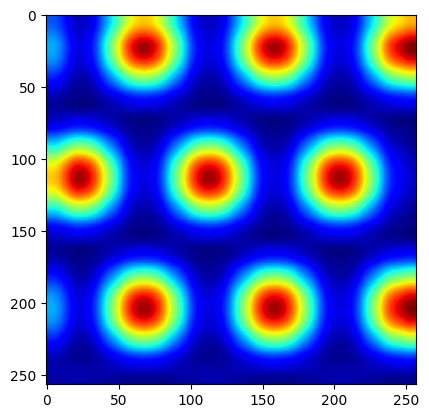

In [12]:
plt.imshow(_interpolate_matrix(circle_left_ex2), cmap='jet')

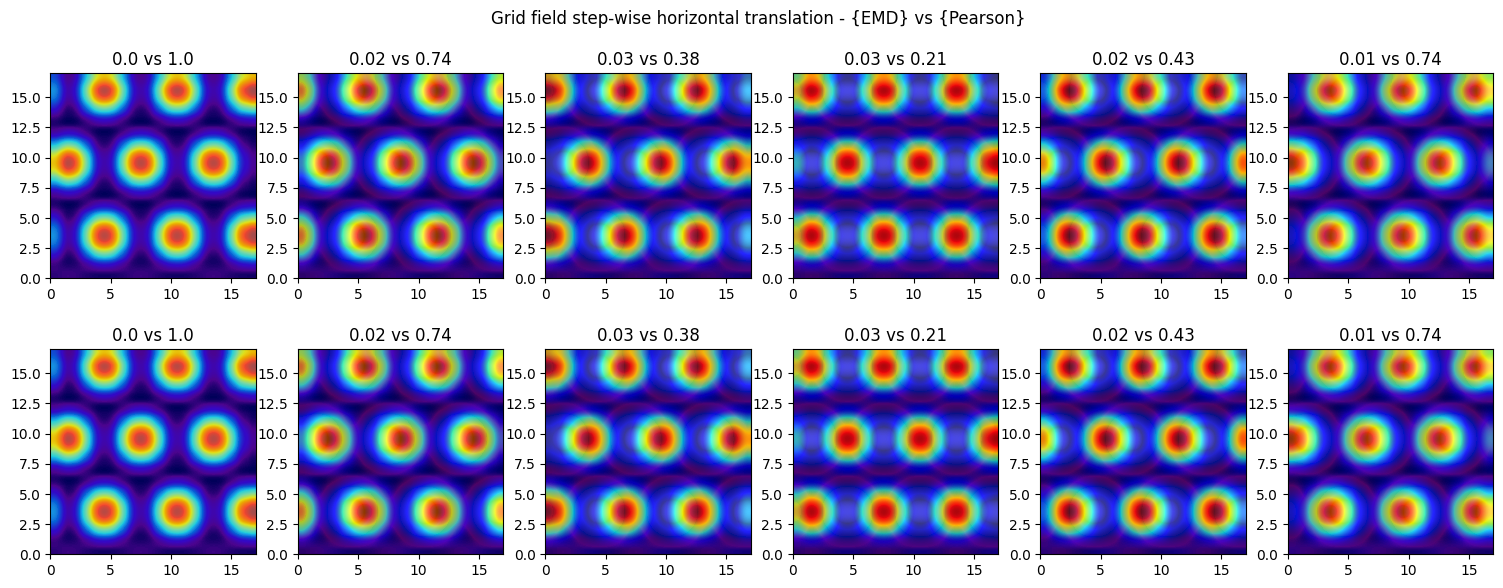

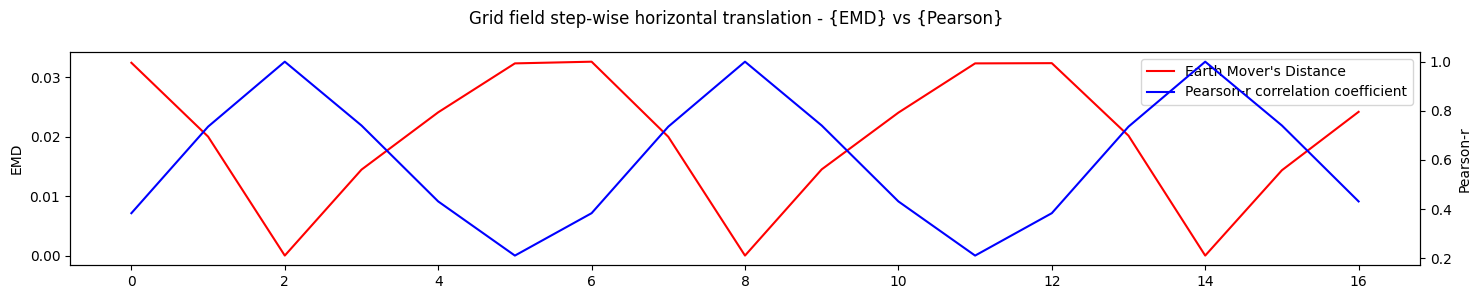

In [13]:
def _interpolate_matrix(matrix, new_size=(257,257), cv2_interpolation_method=cv2.INTER_CUBIC):
    '''
        Interpolate a matrix using cv2.INTER_LANCZOS4.
    '''
    return cv2.resize(matrix, dsize=new_size,
                      interpolation=cv2_interpolation_method)

"""""""""""""""""""""" EXAMPLE 1 """""""""""""""""""""
""" No overlap same shape = elliptic_left_ex1 and elliptic_right_ex1 """

fig = plt.figure(figsize=(15,6))

c = 0
for circle_right_ex2 in aggregate_circle_right_ex2:

    ax = plt.subplot(2,6,c+1)
    ax.imshow(_interpolate_matrix(circle_right_ex2), cmap='jet', extent=[0,sliceN,0,sliceN])
    ax.imshow(_interpolate_matrix(circle_left_ex2), cmap='gist_stern', alpha=0.3, extent=[0,sliceN,0,sliceN])

    y, x = circle_left_ex2.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: circle_left_ex2[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: circle_right_ex2[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    # emd = pot.wass
    r, p = spearmanr(source_weights.flatten(), target_weights.flatten())

    ax.set_title(str(round(emd, 2)) + ' vs ' + str(round(r, 2)))

    c += 1

fig.suptitle('Grid field step-wise horizontal translation - {EMD} vs {Pearson}')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(15,3))
emds = []
pearsons = []
rx, ry = 1, 1
rot = 45
circle_right_ex2_full_grid = make_single_grid(N, sliceN, gapN, full_map_dims, stdev, shift_row=0, shift_col=0, smoothStd=stdev, smooth=True, getFullGrid=True)

for i in np.arange(-int(sliceN/2),ceil(sliceN/2),1):
    # fld = make_single_field(N, stdev, shift_row=-ceil(N/2)+i, shift_col=0 ,custom_gauss=aggregate_elliptic_right_ex1[0])
    # fld = fld[N:N+N,N:N+N]

    # sx, sy = N/2, N/2 + i
    # circle_right_ex2 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 
    # circle_right_ex2 = make_single_grid(N, fullN, stdev, shift_row=0, shift_col=i, smooth=True)
    circle_right_ex2 = circle_right_ex2_full_grid[N+sliceN:sliceN+N+sliceN, N+sliceN + int(i) :sliceN+N+sliceN + int(i)]

    # print(circle_right_ex2.shape, circle_left_ex1.shape)
    y, x = circle_left_ex2.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: circle_left_ex2[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: circle_right_ex2[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    r, p = spearmanr(source_weights.flatten(), target_weights.flatten())

    emds.append(emd)
    pearsons.append(r)

ax  = plt.subplot(1,1,1)
ln1 = ax.plot(emds,label="Earth Mover's Distance",color='r')
axt = ax.twinx()
ln2 = axt.plot(pearsons, label='Pearson-r correlation coefficient',color='b')
ax.set_ylabel('EMD')
axt.set_ylabel('Pearson-r')
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
fig.suptitle('Grid field step-wise horizontal translation - {EMD} vs {Pearson}')
fig.tight_layout()
plt.show()


In [14]:

"""""""""""""""""""""" EXAMPLE 3 - POPULATION FIGURES """""""""""""""""""""
""" Overlap same shape = circle_left_ex1 and circle_right_ex1 """

y, x = circle_left_ex2.shape
height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
source_weights = np.array(list(map(lambda x: circle_left_ex2[x[0],x[1]], buckets)))
source_weights = source_weights / np.sum(source_weights)
coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))
pop_shifted_emd = np.zeros(circle_left_ex2.shape)
pop_shifted_pearson = np.zeros(circle_left_ex2.shape)

circle_right_ex2_full_grid = make_single_grid(N, sliceN, gapN, full_map_dims, stdev, shift_row=0, shift_col=0, smoothStd=stdev ,smooth=True, getFullGrid=True)

rx, ry = 1, 1

def _sub1(i, j):
    sx, sy = i, j
    rot = 45
    # circle_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 
    circle_right_ex2 = circle_right_ex2_full_grid[N+sliceN:sliceN+N+sliceN, N+sliceN + int(i) :sliceN+N+sliceN + int(i)]

    target_weights = np.array(list(map(lambda y: circle_right_ex2[y[0],y[1]], buckets)))
    target_weights = target_weights / np.sum(target_weights)
    
    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    # emd = 0
    r, p = spearmanr(source_weights.flatten(), target_weights.flatten())

    return emd, r

def _sub2(i):
    print(i)
    emd_and_r = np.array(list(map(lambda x: _sub1(i, x), np.arange(0,len(pop_shifted_emd)))))
    return emd_and_r[:,0], emd_and_r[:,1]

combined = np.array(list(map(lambda x: _sub2(x), np.arange(0,len(pop_shifted_emd)))))
pop_shifted_emd, pop_shifted_pearson = combined[:,0,:].T, combined[:,1,:].T


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


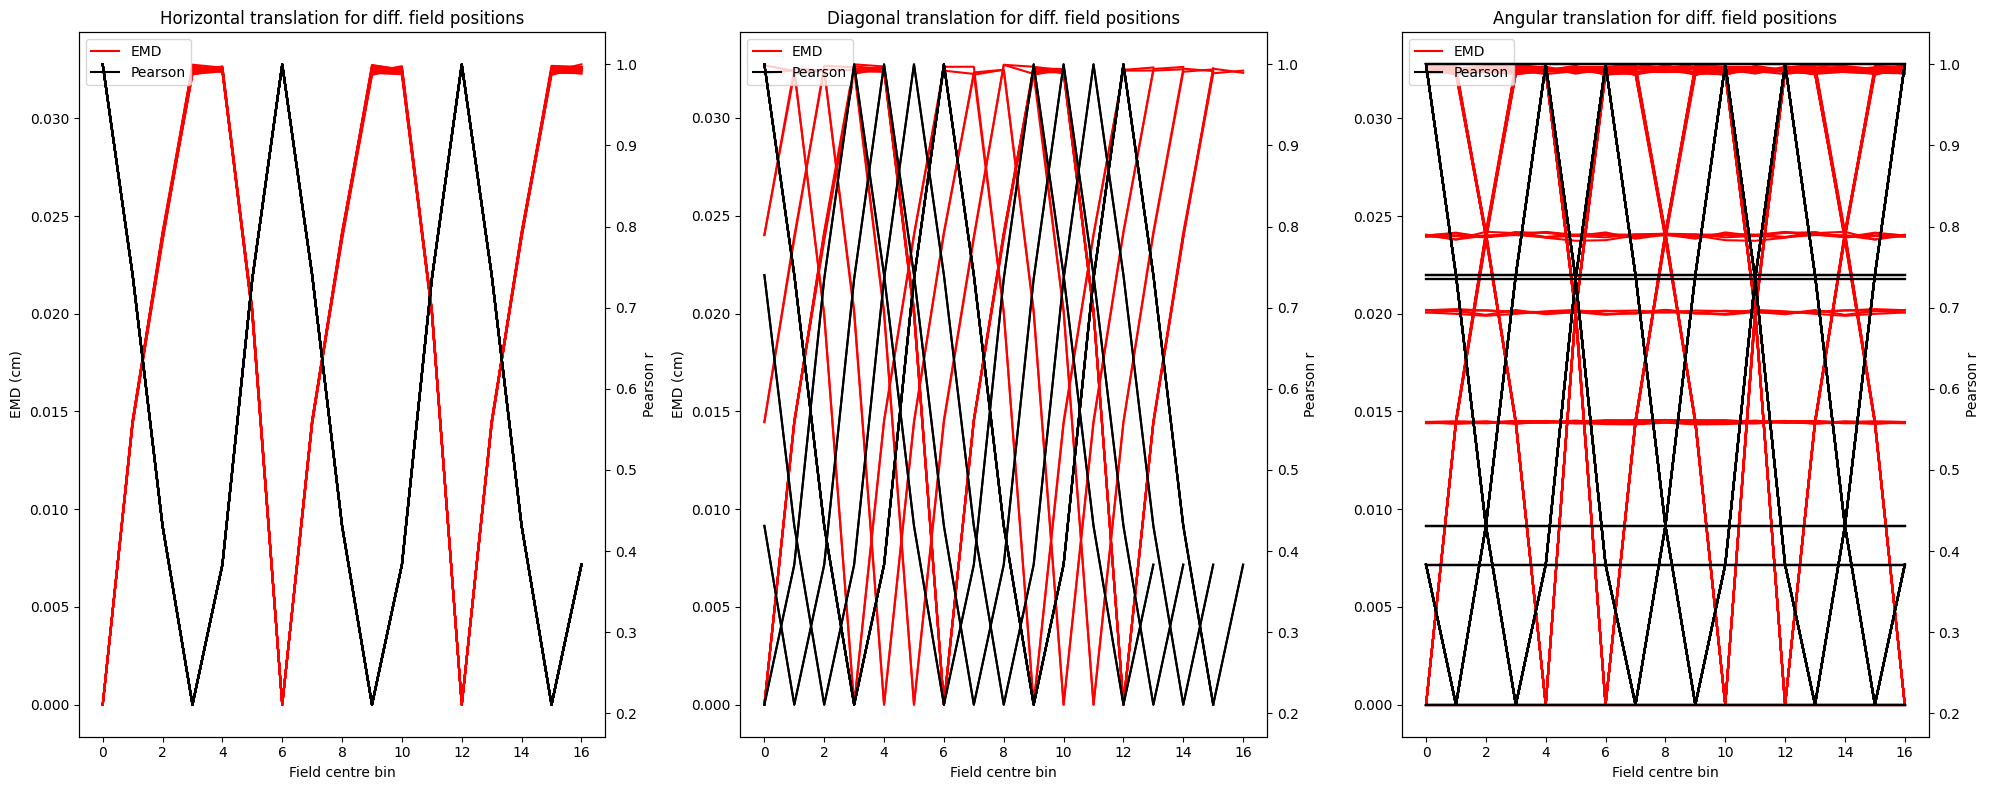

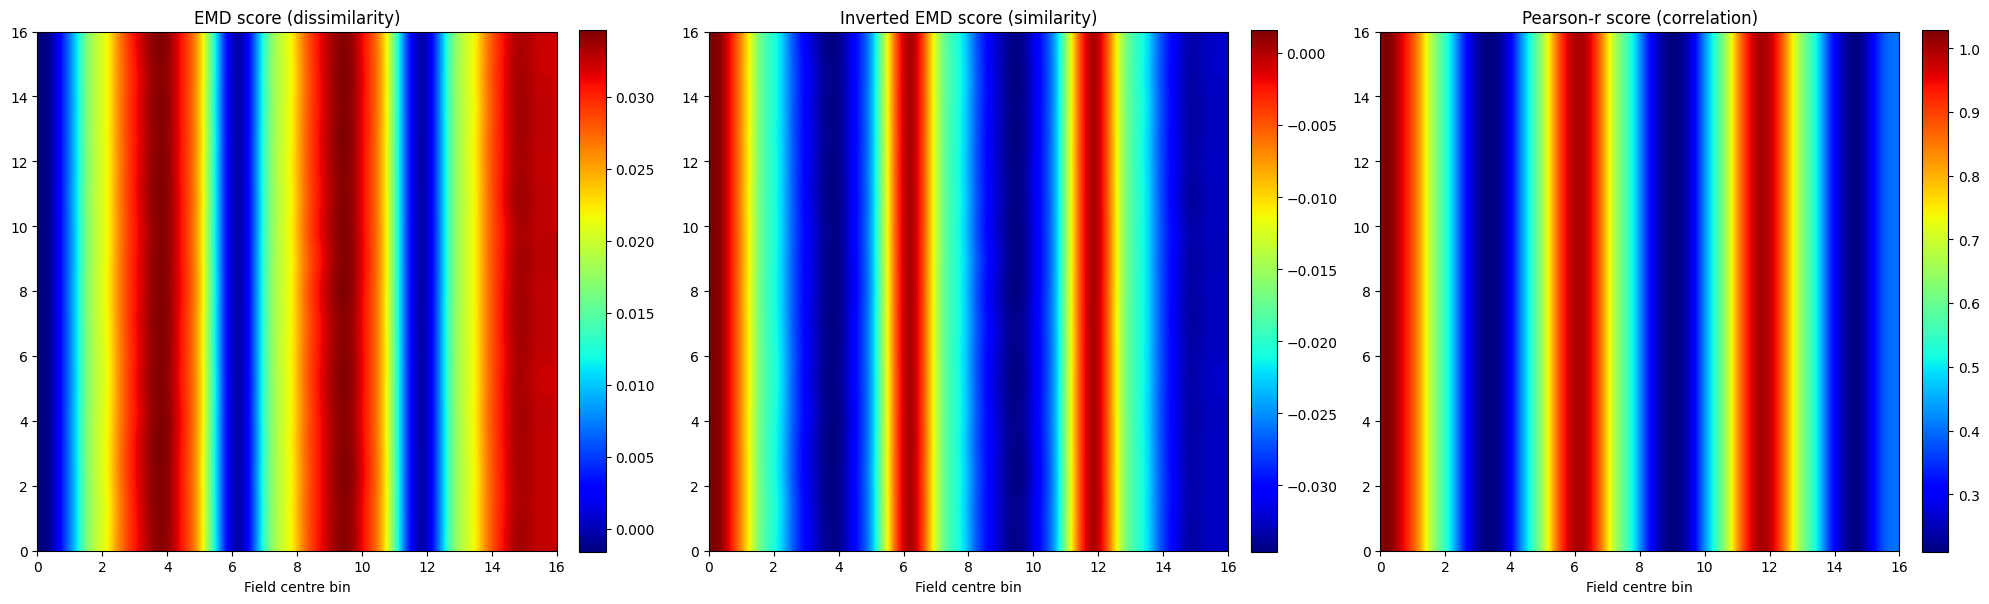

In [15]:
fig, _ = plt.subplots(1, 3, figsize=(20, 8))
ax1 = plt.subplot(1,3,1)
for i in range(len(pop_shifted_emd)):
    p1 = ax1.plot(pop_shifted_emd[i],color='r',label='EMD')
ax1.set_xlabel('Field centre bin')
ax1.set_ylabel('EMD (cm)')
axtwin = ax1.twinx()
axtwin.set_ylabel('Pearson r')
for i in range(len(pop_shifted_pearson)):
    ptwin = axtwin.plot(pop_shifted_pearson[i],color='k',label='Pearson')
lns = p1+ptwin
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')
# ax1.set_aspect('equal')
ax1.set_title('Horizontal translation for diff. field positions')

def diag_matrix(matrix):
    diags = [matrix[::-1,:].diagonal(i) for i in range(-3,4)]
    diags.extend(matrix.diagonal(i) for i in range(3,-4,-1))
    return [n.tolist() for n in diags]

ax2 = plt.subplot(1,3,2)

diag_emd = diag_matrix(pop_shifted_emd)
for i in range(len(diag_emd)):
    p2 = ax2.plot(diag_emd[i],color='r',label='EMD')
ax2.set_xlabel('Field centre bin')
ax2.set_ylabel('EMD (cm)')
axtwin2 = ax2.twinx()
axtwin2.set_ylabel('Pearson r')
diag_pearson = diag_matrix(pop_shifted_pearson)
for i in range(len(diag_pearson)):
    ptwin2 = axtwin2.plot(diag_pearson[i],color='k',label='Pearson')
lns = p2+ptwin2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='upper left')
ax2.set_title('Diagonal translation for diff. field positions')

ax3 = plt.subplot(1,3,3)
rotated_emd = np.array(list(map(lambda x: ndimage.rotate(pop_shifted_emd, x, reshape=False, mode='constant', cval=np.nan), np.arange(0,360,90))))
pdct_emd = list(itertools.product(np.arange(len(rotated_emd)), np.arange(len(rotated_emd[0]))))
list(map(lambda x: ax3.plot(rotated_emd[x[0],x[1]],color='r',label='EMD'), pdct_emd))
p3 = ax3.plot(rotated_emd[0,0],color='r',label='EMD')
# for i in range(len(rotated_emd)):
#     for j in range(len(rotated_emd[i])):
axtwin3 = ax3.twinx()
axtwin3.set_ylabel('Pearson r')
rotated_pearson = np.array(list(map(lambda x: ndimage.rotate(pop_shifted_pearson, x, reshape=False, mode='constant', cval=np.nan), np.arange(0,360,90))))
# for i in range(len(rotated_pearson)):
#     for j in range(len(rotated_pearson[i])):
pdct_pearson = list(itertools.product(np.arange(len(rotated_pearson)), np.arange(len(rotated_pearson[0]))))
list(map(lambda x: axtwin3.plot(rotated_pearson[x[0],x[1]],color='k',label='EMD'), pdct_pearson))
ptwin3 = axtwin3.plot(rotated_pearson[0,0],color='k',label='Pearson')
lns = p3+ptwin3
labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, loc='upper left')
ax3.set_title('Angular translation for diff. field positions')
ax3.set_xlabel('Field centre bin')

fig.tight_layout()
plt.show()

fig, _ = plt.subplots(1, 2, figsize=(20, 8))

ax4 = plt.subplot(1,3,1)
im = ax4.imshow(_interpolate_matrix(pop_shifted_emd), cmap='jet', aspect='equal', extent=[0,sliceN-1,0,sliceN-1])
ax4.set_title('EMD score (dissimilarity)')
ax4.set_xlabel('Field centre bin')
fig.colorbar(im, ax=ax4,fraction=0.046, pad=0.04)

ax5 = plt.subplot(1,3,2)
im = ax5.imshow(_interpolate_matrix(-pop_shifted_emd), cmap='jet', aspect='equal', extent=[0,sliceN-1,0,sliceN-1])
ax5.set_title('Inverted EMD score (similarity)')
ax5.set_xlabel('Field centre bin')
fig.colorbar(im, ax=ax5,fraction=0.046, pad=0.04)

ax6 = plt.subplot(1,3,3)
ax6.set_xlabel('Field centre bin')
im = ax6.imshow(_interpolate_matrix(pop_shifted_pearson), cmap='jet', aspect='equal', extent=[0,sliceN-1,0,sliceN-1])
ax6.set_title('Pearson-r score (correlation)')
fig.colorbar(im, ax=ax6,fraction=0.046, pad=0.04)

fig.tight_layout()
plt.show()